In [5]:
import pyprob
import numpy as np
import ot
import torch
import cProfile
import pickle

from pyprob.dis import ModelDIS
from showerSim import invMass_ginkgo
from torch.utils.data import DataLoader
from pyprob.nn.dataset import OnlineDataset
from pyprob.util import InferenceEngine
from pyprob.util import to_tensor
from pyprob import Model
from pyprob.model import Parallel_Generator
import math
from pyprob.distributions import Normal
from pyprob.distributions.delta import Delta


import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as mpl_cm
plt.ion()

import sklearn as skl
from sklearn.linear_model import LinearRegression

from geomloss import SamplesLoss
sinkhorn = SamplesLoss(loss="sinkhorn", p=1, blur=.05)
def sinkhorn_t(x,y):
    x = to_tensor(x)
    y = torch.stack(y)
    return sinkhorn(x,y)


def ot_dist(x,y):
    # x = to_tensor(x)
    # y = torch.stack(y)
    x = np.array(x)
    y = np.array(torch.stack(y))
    a = ot.unif(len(x))
    b = ot.unif(len(y))
    Mat = ot.dist(x, y, metric='euclidean')
    #Mat1 /= Mat1.max()
    distance = to_tensor(ot.emd2(a,b,Mat))
    return distance


device = "cpu"

from pyprob.util import set_device
set_device(device)

obs_leaves = to_tensor([[ 25.8005,  15.8486,  13.7905,  14.9743],
        [ 64.6767,  39.8886,  34.8096,  37.1519],
        [112.1183,  68.9756,  59.4660,  65.3958],
        [ 17.2854,   9.8922,   9.2324,  10.7553],
        [  8.0760,   4.8046,   4.1940,   4.9540],
        [ 32.6218,  17.6533,  21.0402,  17.6020],
        [ 78.1670,  42.4337,  50.0361,  42.4953],
        [ 23.3093,  12.4575,  14.6925,  13.1246],
        [  8.5133,   4.5174,   5.0757,   5.1276],
        [ 17.5119,   8.7775,  10.6228,  10.8064],
        [ 11.6579,   5.0303,   7.2342,   7.6330],
        [  0.8138,   0.3167,   0.5029,   0.5491],
        [  0.5715,   0.3441,   0.2433,   0.3707]])


QCD_mass = to_tensor(30.)
#rate=to_tensor([QCD_rate,QCD_rate]) #Entries: [root node, every other node] decaying rates. Choose same values for a QCD jet
jetdir = to_tensor([1.,1.,1.])
jetP = to_tensor(400.)
jetvec = jetP * jetdir / torch.linalg.norm(jetdir) ## Jetvec is 3-momentum. JetP is relativistic p.


# Actual parameters
pt_min = to_tensor(0.3**2)
M2start = to_tensor(QCD_mass**2)
jetM = torch.sqrt(M2start) ## Mass of initial jet
jet4vec = torch.cat((torch.sqrt(jetP**2 + jetM**2).reshape(-1), jetvec))
minLeaves = 1
maxLeaves = 10000 # unachievable, to prevent rejections
maxNTry = 100



class SimulatorModelDIS(invMass_ginkgo.SimulatorModel, ModelDIS):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def dummy_bernoulli(self, jet):
        return True

    def forward(self, inputs=None):
        assert inputs is None # Modify code if this ever not met?
        # Sample parameter of interest from Unif(0,10) prior
        root_rate = pyprob.sample(pyprob.distributions.Uniform(0.01, 10.),
                                  name="decay_rate_parameter")
        decay_rate = pyprob.sample(pyprob.distributions.Uniform(0.01, 10.),
                                   name="decay_rate_parameter")
        # Simulator code needs two decay rates for (1) root note (2) all others
        # For now both are set to the same value
        inputs = [root_rate, decay_rate]
        jet = super().forward(inputs)
        delta_val = self.dummy_bernoulli(jet)
        bool_func_dist = pyprob.distributions.Bernoulli(delta_val)
        pyprob.observe(bool_func_dist, name = "dummy")
        return jet

# Make instance of the simulator
simulatorginkgo = SimulatorModelDIS(jet_p=jet4vec,  # parent particle 4-vector
                                    pt_cut=float(pt_min),  # minimum pT for resulting jet
                                    Delta_0= M2start,  # parent particle mass squared -> needs tensor
                                    M_hard=jetM,  # parent particle mass
                                    minLeaves=1,  # minimum number of jet constituents
                                    maxLeaves=10000,  # maximum number of jet constituents (a large value to stop expensive simulator runs)
                                    suppress_output=True,
                                    obs_leaves=obs_leaves,
                                    dist_fun=sinkhorn_t)

In [7]:
with open('network_parallel/LSTM_posterior_10', 'rb') as f:
    posterior10 = pickle.load(f)

In [19]:
with open('network_parallel/LSTM_posterior_80', 'rb') as f:
    posterior80 = pickle.load(f)

In [17]:
rates10 = np.array([trace.result['Lambda'] for trace in posterior10])

In [20]:
rates80 = np.array([trace.result['Lambda'] for trace in posterior80])

(array([  4.,   1.,   1.,  44., 219., 582., 677., 361.,  98.,  13.]),
 array([0.02346739, 0.4450662 , 0.86666507, 1.2882639 , 1.7098627 ,
        2.1314616 , 2.5530603 , 2.9746592 , 3.396258  , 3.8178568 ,
        4.2394557 ], dtype=float32),
 <BarContainer object of 10 artists>)

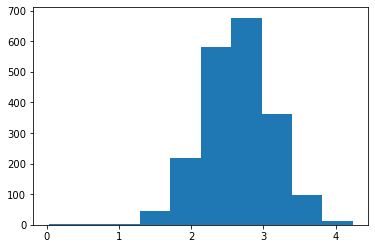

In [21]:
plt.hist(rates10)

(array([1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.998e+03]),
 array([2.5552664, 3.2997375, 4.0442085, 4.7886796, 5.5331507, 6.2776217,
        7.022093 , 7.766564 , 8.511035 , 9.2555065, 9.999977 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

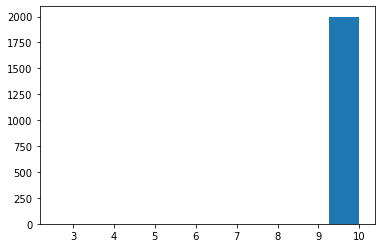

In [22]:
plt.hist(rates80)

In [23]:
root_rates10 = np.array([trace.result['LambdaRoot'] for trace in posterior10])

In [24]:
root_rates80 =  np.array([trace.result['LambdaRoot'] for trace in posterior80])

(array([  9.,  12.,  26.,  53.,  91., 165., 277., 381., 468., 518.]),
 array([0.13637829, 1.1227068 , 2.1090353 , 3.0953639 , 4.081692  ,
        5.068021  , 6.0543494 , 7.040678  , 8.027006  , 9.013335  ,
        9.999663  ], dtype=float32),
 <BarContainer object of 10 artists>)

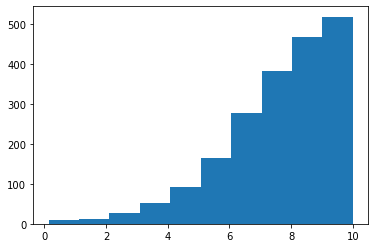

In [25]:
plt.hist(root_rates10)

(array([  4.,   8.,  37.,  80., 128., 224., 319., 374., 429., 397.]),
 array([9.372334, 9.43506 , 9.497786, 9.560512, 9.623238, 9.685965,
        9.748691, 9.811417, 9.874143, 9.936869, 9.999595], dtype=float32),
 <BarContainer object of 10 artists>)

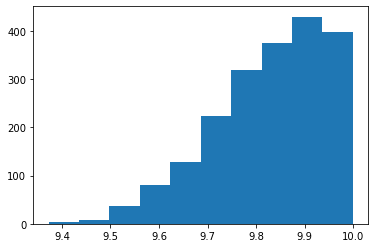

In [26]:
plt.hist(root_rates80)

In [27]:
rates80

array([9.994822, 9.977611, 9.994802, ..., 9.958442, 9.984302, 9.979695],
      dtype=float32)

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0., 1998.]),
 array([ 9.        ,  9.11111111,  9.22222222,  9.33333333,  9.44444444,
         9.55555556,  9.66666667,  9.77777778,  9.88888889, 10.        ]),
 <BarContainer object of 9 artists>)

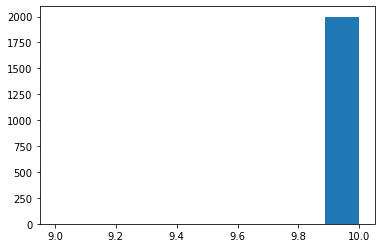

In [34]:
plt.hist(rates80, bins = np.linspace(9,10,10))

In [32]:
np.linspace(9,10,10)

array([ 9.        ,  9.11111111,  9.22222222,  9.33333333,  9.44444444,
        9.55555556,  9.66666667,  9.77777778,  9.88888889, 10.        ])

conftest.py               inference_network_8
DIS_tests-2.ipynb         inference_network_9
DIS_tests.ipynb           LSTM_network_original/
DIS_tests_parallel.ipynb  network_parallel/
extra/                    network_parallel_2/
ginkgo_fixed_network_2    New_LSTM_Network_20
Ginkgo_Full_Tests.ipynb   Old_LSTM_Network_20
Ginkgo_LSTM2.py           Old_LSTM_Network_40
Ginkgo_LSTM.py            Parallel_posterior.ipynb
ginkgo_parallel.py        run_all.sh
inference_network_0       run_basic.sh
inference_network_1       run_inference.sh
inference_network_10      Save_Test1
inference_network_11      test_dataset.py
inference_network_12      test_diagnostics.py
inference_network_13      test_distributions.py
inference_network_14      test_distributions_remote.py
inference_network_15      test_inference.py
inference_network_16      test_inference_remote.py
inference_network_17      test_model.py
inference_network_18      test_model_remote.py
inference_network_19      test_nn.py
inference_netw

In [2]:
simulatorginkgo.load_inference_network('New_LSTM_Network_20')

In [3]:
posterior_results = simulatorginkgo.posterior_results(num_traces = 1000, inference_engine=InferenceEngine.DISTILLING_IMPORTANCE_SAMPLING,observe = {'dummy':1})

Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__12
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 256__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__12
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 460__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_re

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__13
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 256__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__13
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 460__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_re

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__16
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 256__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__16
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 460__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExpo

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__10
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 256__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__10
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 460__forward___traverse___traverse_rec___traverse_rec___traverse_re

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__1
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 256__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_re

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__10
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 256__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__10
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 460__forward___traverse___traverse_re

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__13
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 256__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__13
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 460__forward___traverse___traverse_rec___traverse_rec___traverse_re

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__14
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 256__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__14
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 460__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_re

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__15
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 256__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__15
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 460__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_re

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 510__forward___traverse___traverse_rec___traverse_rec___traverse_rec__draw_decay_R__TruncatedExponential__5
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__15
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 256__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__15
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 460__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_re

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__2
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 256__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__2
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/disp

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__10
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 256__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__10
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 460__fo

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__17
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 256__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__17
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 460__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExpo

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__18
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 256__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__18
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 460__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExpo

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__16
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 256__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__16
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 460__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__16
  warnings.warn('Using prior. No 

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__17
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 256__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__17
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 460__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__17
  warnings.warn('Using prior. No 

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__16
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 256__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__16
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 460__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_re

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__13
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 256__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__13
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 460__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__13
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/h

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__6
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 256__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__6
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inferen

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 460__forward___traverse___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__3
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__18
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 256__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__18
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 460__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_re

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 460__forward___traverse___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__5
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__8
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 256__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__8
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: 

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__14
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 256__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__14
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 460__forward___traverse___traverse_rec___traverse_rec___traverse_re

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 460__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__3
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__11
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 256__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__11
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 460__fo

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 510__forward___traverse___traverse_rec___traverse_rec__draw_decay_R__TruncatedExponential__3
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__14
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 256__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__14
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 460__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__14
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/h

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__19
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 256__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__19
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 460__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_re

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__15
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 256__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__15
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 460__forward___traverse___traverse_rec___traverse_rec___traverse_re

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 510__forward___traverse___traverse_rec__draw_decay_R__TruncatedExponential__2
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__9
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 256__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec_

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__19
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 256__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__19
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 460__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExpo

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__2
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 256__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__2
  warnings.warn('Using prior. No p

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__3
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 256__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__3
  warnings.warn('Using prior. No proposal for address: {}'.forma

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 510__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_R__TruncatedExponential__9
  warnings.warn('Using prior. No proposal for address: {}'.format(address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__15
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 256__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__15
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 460__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__15
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/h

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__10
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 256__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__10
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No

/home/tt21642/dispyprob/pyprob/pyprob/model.py:204: UserWarning: Encountered trace with nan, inf, or -inf log_weight. Discarding trace.
  warnings.warn('Encountered trace with nan, inf, or -inf log_weight. Discarding trace.')


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__2
  warnings.warn('Using prior. No proposal for address: {}'.format(address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_feedforward.py:67: UserWarning: Using prior. No proposal for address: 256__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__theta_CM_U__Uniform__2
  wa

0d:01:11:34 | 0d:00:00:04 | #################### | 1000/1000 |  10.76 | 0.23       


In [7]:
imurates20 = np.array([value['Lambda'] for value in posterior_results])

(array([111.,  91., 109.,  97.,  93.,  96.,  98.,  92., 104., 108.]),
 array([0.01652765, 1.0124531 , 2.0083785 , 3.0043042 , 4.0002294 ,
        4.996155  , 5.9920807 , 6.988006  , 7.9839315 , 8.9798565 ,
        9.975782  ], dtype=float32),
 <BarContainer object of 10 artists>)

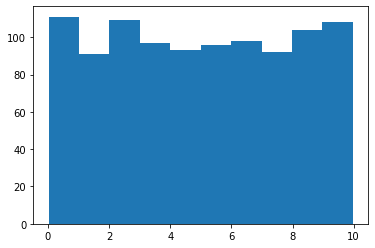

In [8]:
plt.hist(rates20)

# Old Network

In [8]:
obs_leaves2 = to_tensor([[44.57652381, 26.16169856, 25.3945314 , 25.64598258],
                        [18.2146321 , 10.70465096, 10.43553391, 10.40449709],
                        [ 6.47106713,  4.0435395,  3.65545951,  3.48697568],
                        [ 8.43764314,  5.51040615,  4.60990593,  4.42270416],
                        [26.61664145, 16.55894826, 14.3357362 , 15.12215264],
                        [ 8.62925002,  3.37121204,  5.19699   ,  6.00480461],
                        [ 1.64291837,  0.74506775,  1.01003622,  1.05626017],
                        [ 0.75525072,  0.3051808 ,  0.45721085,  0.51760643],
                        [39.5749915 , 18.39638928, 24.24717939, 25.29349408],
                        [ 4.18355659,  2.11145474,  2.82071304,  2.25221316],
                        [ 0.82932922,  0.29842766,  0.5799056 ,  0.509021  ],
                        [ 3.00825023,  1.36339397,  1.99203677,  1.79428211],
                        [ 7.20024308,  4.03280868,  3.82379277,  4.57441754],
                        [ 2.09953618,  1.28473579,  1.03554351,  1.29769683],
                        [12.21401828,  6.76059035,  6.94920042,  7.42823701],
                        [ 6.91438054,  3.68417135,  3.83782514,  4.41656731],
                        [ 1.97218904,  1.01632927,  1.08008339,  1.27454585],
                        [ 8.58164301,  5.06157833,  4.79691164,  4.99553141],
                        [ 5.97809522,  3.26557958,  3.4253764 ,  3.64894791],
                        [ 5.22842301,  2.94437891,  3.10292633,  3.00551074],
                        [15.40023764,  9.10884407,  8.93836964,  8.61970667],
                        [ 1.96101346,  1.24996337,  1.06923988,  1.06743143],
                        [19.81054106, 11.90268453, 11.60989346, 10.76953856],
                        [18.79470876, 11.429855  , 10.8377334 , 10.25112761],
                        [25.74331932, 15.63430056, 14.83860792, 14.07189108],
                        [ 9.98357576,  6.10090721,  5.68664128,  5.48748692],
                        [12.34604239,  7.78770185,  6.76075998,  6.78498685],
                        [21.24998531, 12.95180254, 11.9511704 , 11.87319933],
                        [ 7.80693733,  4.83117128,  4.27443559,  4.39602348],
                        [16.28983576,  9.66683929,  9.24891886,  9.28970032],
                        [ 2.50706736,  1.53153206,  1.36060018,  1.43002765],
                        [ 3.73938645,  2.06006639,  2.31013974,  2.09378969],
                        [20.2174725 , 11.88622367, 12.05106468, 11.05325362],
                        [ 9.48660008,  5.53665456,  5.54171966,  5.34966654],
                        [ 2.65812987,  1.64102742,  1.67392209,  1.25083707]])

simulatorginkgo2 = SimulatorModelDIS(jet_p=jet4vec,  # parent particle 4-vector
                                    pt_cut=float(pt_min),  # minimum pT for resulting jet
                                    Delta_0= M2start,  # parent particle mass squared -> needs tensor
                                    M_hard=jetM,  # parent particle mass
                                    minLeaves=1,  # minimum number of jet constituents
                                    maxLeaves=10000,  # maximum number of jet constituents (a large value to stop expensive simulator runs)
                                    suppress_output=True,
                                    obs_leaves=obs_leaves2,
                                    dist_fun=sinkhorn_t)

In [12]:
posteriors = []
for i in range(10,90,10):
    simulatorginkgo2.load_inference_network(f'LSTM_network_original/LSTM_network_{i}')
    posterior = simulatorginkgo2.posterior(num_traces = 1000, inference_engine=InferenceEngine.DISTILLING_IMPORTANCE_SAMPLING,observe = {'dummy':1})
    posterior = simulatorginkgo2.update_DIS_weights(posterior)
    posteriors.append(posterior)

Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__1
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__1
  

0d:01:24:12 | 0d:00:00:05 | #################### | 1000/1000 |   2.08 | 0.20       
Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 460__forward___traverse___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__3
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 460__forward___traverse___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__3
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:107: UserWarning: Address of previous variable unknown by inference network: 460__forward___traverse___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__3
  warnings.warn('Address of previous variable unknown by inference network: {}'.format(prev_address))
/home/tt21642/dispypr

/home/tt21642/dispyprob/pyprob/pyprob/model.py:204: UserWarning: Encountered trace with nan, inf, or -inf log_weight. Discarding trace.
  warnings.warn('Encountered trace with nan, inf, or -inf log_weight. Discarding trace.')


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 460__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__9
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 460__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__9
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:107: UserWarning: Address of previous variable unknown by inference network: 460__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__9
  warnings.warn('Address of previ

0d:02:05:56 | 0d:00:00:07 | #################### | 1000/1000 |   1.00 | 0.13       
Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__11
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__11
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:107: UserWarning: Address of previous variable unknown by inference network: 216__forward___traverse___traverse_rec___t

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__15
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__15
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:107: UserWarning: Address of previous variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___t

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 510__forward___traverse___traverse_rec___traverse_rec___traverse_rec__draw_decay_R__TruncatedExponential__5
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 510__forward___traverse___traverse_rec___traverse_rec___traverse_rec__draw_decay_R__TruncatedExponential__5
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:107: UserWarning: Address of previous variable unknown by inference network: 510__forward___traverse___traverse_rec___traverse_rec___traverse_rec__draw_decay_R__TruncatedExponential__5
  warnings.warn('Address of previous variable unknown by inference network: {}'.format(prev_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__6
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


0d:03:16:42 | 0d:00:00:11 | #################### | 1000/1000 |   1.03 | 0.08       
Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__10
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__10
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:107: UserWarning: Address of previous variable unknown by inference network: 216__forward

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__2
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__8
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__12
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__4
  warnings.warn('Using prior. 

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__9
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__9
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:107: UserWarning: Address of previous variable unknown by inf

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__7
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__7
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:107: UserWarning: Address of pr

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__9
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__11
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__7
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 510__forward___traverse___traverse_rec___traverse_rec__draw_decay_R__TruncatedExponential__3
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 510__forward___traverse___traverse_rec___traverse_rec__draw_decay_R__TruncatedExponential__3
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispy

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__7
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__5
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__5
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__8
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__8
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:107: UserWarning: Address of pr

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__5
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__5
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:1

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__3
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__3
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__10
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__3
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__1
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__4
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec__

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__1
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___trave

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__2
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__3
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___trav

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__10
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 460__forward___traverse___traverse_rec__draw_decay_L__TruncatedExponential__2
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 460__forward___traverse___traverse_rec__draw_decay_L__TruncatedExponential__2
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:107: UserWarning: Address of previous variable unknown by inference network: 460__forward___traverse___traverse_rec__draw_decay_L__TruncatedExponential__2
  warnings.warn('Address of previous variable unknown by inference network: {}'.format(prev_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__10
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__1
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___trave

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__2
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__5
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:1

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__5
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__9
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__15
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__15
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:107: UserWarning: Address of previous variable unknown by inference network: 216__forward___traverse___traverse_rec___t

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__3
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__2
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__13
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__9
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__2
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__5
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__4
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__6
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___trav

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__7
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__3
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__11
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__15

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__9
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec__phi_CM__Uniform__2
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 510__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_R__TruncatedExponential__14
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__8
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__15
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__16
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 460__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__17
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 460__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__17
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:107: UserWarning: Address of previous variable unknown by inference network: 460__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__4
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__3
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__3
  warnings.warn('Using prior. No

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__14
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__17
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___travers

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__8
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__6
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__4
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__3
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 510__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_R__TruncatedExponential__7
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 510__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_R__TruncatedExponential__7
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__10
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__3
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__10
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarnin

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__7
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 510__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_R__TruncatedExponential__9
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__5
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__13
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__7
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__8
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__12
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 510__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_R__TruncatedExponential__8
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__5
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__11
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__5
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__9
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__9
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:1

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__14
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__16
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___travers

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__17
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__17
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:107: UserWarning: Address of previous variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___t

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__5
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 460__forward___traverse___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__5
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 460__forward___traverse___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__5
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:107: UserWarning: Address of previous variable unknown by inference network: 460__forward___traverse___traverse_rec___traverse_rec___traverse_rec__draw_decay_L__TruncatedExponential__5
  warnings.warn('Address of previous variable unknown by inference network: {}

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__13
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__18
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__18
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:107: UserWarning: Address of previous variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___t

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__17
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__17
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:107: UserWarning: Address of previous variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__14
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__14
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:107: UserWarning: Address of previous variable unknown by inference network: 216__forward

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__3
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__18
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__18
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:107: UserWarning: Address of previous variable unknown by inference network: 216__forward___traverse___traverse_rec___t

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__3
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 510__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_R__TruncatedExponential__10
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__19
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__19
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:107: UserWarning: Address of previous variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___t

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__14
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__14
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:107: UserWarning: Address of previous variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__14
  warnings.warn('Address of previous varia

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:107: UserWarning: Address of previous variable unknown by inference network: 510__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_R__TruncatedExponential__17
  warnings.warn('Address of previous variable unknown by inference network: {}'.format(prev_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__6
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__6
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__6
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__19
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__19
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:107: UserWarning: Address of previous variable unknown by inference network: 216__forward___traverse___traverse_rec___t

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__18
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__18
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:107: UserWarning: Address of previous variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___t

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__19
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__19
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:107: UserWarning: Address of previous variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___t

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__13
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__13
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:107: UserWarning: Address of previous variable unknown by i

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__7
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__7
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__4
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__4
  warnings.warn('Using prior. No

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__1
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__9
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt

0d:05:14:50 | 0d:00:00:18 | #################### | 1000/1000 |  13.48 | 0.05       
Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 510__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_R__TruncatedExponential__15
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 510__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_R__TruncatedExponential__15
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:107: UserWarning: Address of previous variable unkn

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__14
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__13
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__3
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 510__forward___traverse___traverse_rec__draw_decay_R__TruncatedExponential__2
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 510__forward___traverse___traverse_rec__draw_decay_R__TruncatedExponential__2
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:107: UserWarning: Address of previous variable unknown by inference network: 510__forward___traverse___traverse_rec__draw_decay_R__TruncatedExponential__2
  warnings.warn('Address of previous variable unknown by inference network: {}'.format(prev_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__12
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__12
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:107: UserWarning: Address of 

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:107: UserWarning: Address of previous variable unknown by inference network: 510__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_R__TruncatedExponential__17
  warnings.warn('Address of previous variable unknown by inference network: {}'.format(prev_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__18
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 510__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_R__TruncatedExponential__15
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__3
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__3
  

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 510__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_R__TruncatedExponential__4
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__13
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__13
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:107: UserWarning: Address of 

/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__16
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 216__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec___traverse_rec__phi_CM__Uniform__16
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:107: UserWarning: Address of previous variable unknown by inference network: 216__forward

0d:03:40:15 | 0d:00:00:13 | #################### | 1000/1000 |  20.84 | 0.08       
Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec
0d:01:42:44 | 0d:00:00:06 | #################### | 1000/1000 |   1.34 | 0.16       
Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec


/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:116: UserWarning: Address of current variable unknown by inference network: 510__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_R__TruncatedExponential__9
  warnings.warn('Address of current variable unknown by inference network: {}'.format(current_address))
/home/tt21642/dispyprob/pyprob/pyprob/nn/inference_network_lstm.py:137: UserWarning: Using prior. No proposal for address: 510__forward___traverse___traverse_rec___traverse_rec___traverse_rec___traverse_rec__draw_decay_R__TruncatedExponential__9
  warnings.warn('Using prior. No proposal for address: {}'.format(current_address))


0d:01:37:12 | 0d:00:00:05 | #################### | 1000/1000 |   5.22 | 0.17       
Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec
0d:02:23:59 | 0d:00:00:08 | #################### | 1000/1000 |   6.04 | 0.12       


In [26]:
def posterior_result_weight(posterior):
    results = np.array([trace.result['Lambda'] for trace in posterior])
    log_weights = np.array([trace.log_importance_weight for trace in posterior])
    weights = np.exp(log_weights)
    weights /= weights.sum()
    return (results, weights)

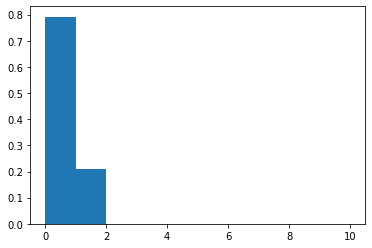

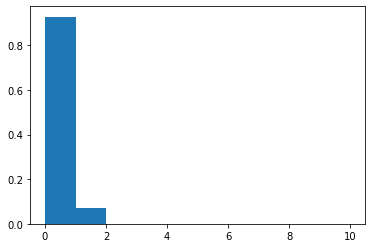

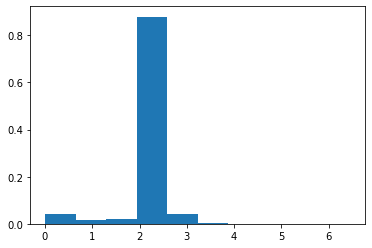

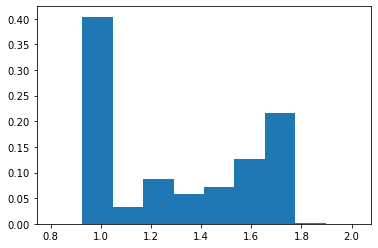

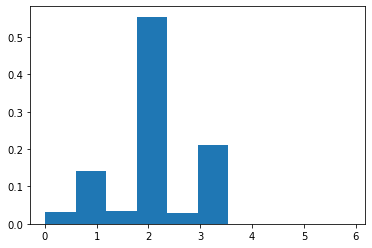

In [30]:
for posterior in posteriors[3:]: # Accidentally overwrote first 10 runs of inference network with wrong network
    results, weight = posterior_result_weight(posterior)
    plt.figure()
    plt.hist(results, weights=weight)

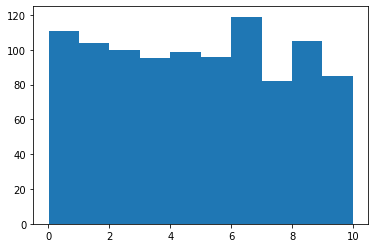

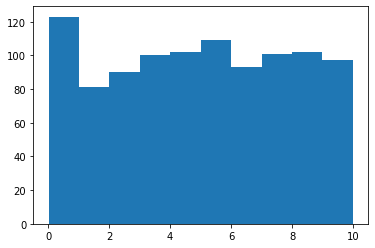

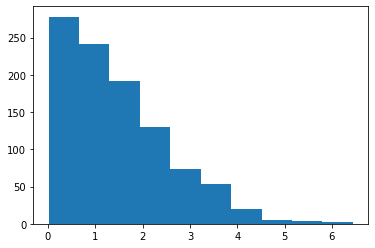

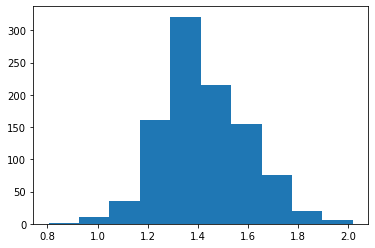

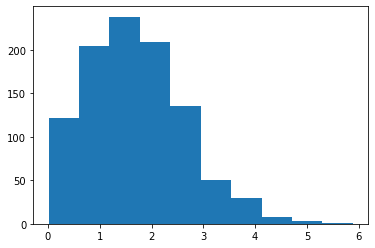

In [29]:
for posterior in posteriors[3:]: # Accidentally overwrote first few runs of inference network with wrong network
    results, weight = posterior_result_weight(posterior)
    plt.figure()
    plt.hist(results)

# New Networks

In [5]:
def posterior_result_weight(posterior):
    results = np.array([trace.result['Lambda'] for trace in posterior])
    log_weights = np.array([trace.log_importance_weight for trace in posterior])
    weights = np.exp(log_weights)
    weights /= weights.sum()
    return (results, weights)

In [3]:
with open('network_parallel_3/LSTM_posterior_1', 'rb') as f:
    posterior1 = pickle.load(f)

In [7]:
with open('network_parallel_3/LSTM_posterior_2', 'rb') as f:
    posterior2 = pickle.load(f)

(array([0.00460061, 0.02633351, 0.043273  , 0.1387616 , 0.20249189,
        0.1000183 , 0.06605617, 0.12175754, 0.03457719, 0.26213019]),
 array([0.01053476, 1.009403  , 2.0082712 , 3.0071394 , 4.0060077 ,
        5.004876  , 6.003744  , 7.002612  , 8.00148   , 9.000349  ,
        9.999217  ], dtype=float32),
 <BarContainer object of 10 artists>)

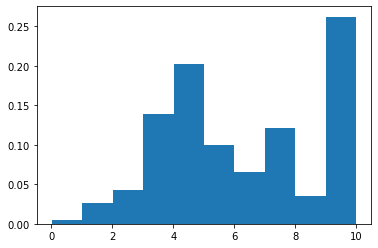

In [7]:
    results, weight = posterior_result_weight(posterior1)
    plt.figure()
    plt.hist(results, weights=weight)

In [6]:
results, weight = posterior_result_weight(posterior2)
plt.figure()
plt.hist(results, weights = weight)

NameError: name 'posterior_result_weight' is not defined

In [1]:
def posterior_result_weight2(posterior):
    results = np.array([trace.result['LambdaRoot'] for trace in posterior])
    log_weights = np.array([trace.log_importance_weight for trace in posterior])
    weights = np.exp(log_weights)
    weights /= weights.sum()
    return (results, weights)

(array([170., 173., 202., 196., 204., 193., 201., 227., 235., 198.]),
 array([0.01027155, 1.0084877 , 2.0067039 , 3.0049202 , 4.003136  ,
        5.0013523 , 5.999569  , 6.997785  , 7.9960012 , 8.994217  ,
        9.992434  ], dtype=float32),
 <BarContainer object of 10 artists>)

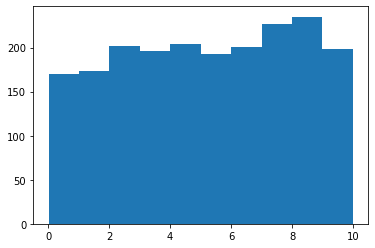

In [9]:
results, weight = posterior_result_weight2(posterior2)
plt.hist(results)